In [1]:
# Single cell instances for contact sheet

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/MovieEdges
Tue Jun 28 00:07:09 PDT 2022


In [3]:
import os
import sys
import json
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control_main = controller.Controller(general.load_config_file(path_config))
device_main = io.LocalStagingIO(control_main)
print(control_main.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
df = device_main.load_step_manifest("loaddata")
print(df.shape)

(216062, 46)


In [6]:
genes = control_main.get_gene_names()

In [7]:
with open("contrast_V3_90OnValids.json", "r") as fj:
    contrast = json.load(fj)["contrast"]

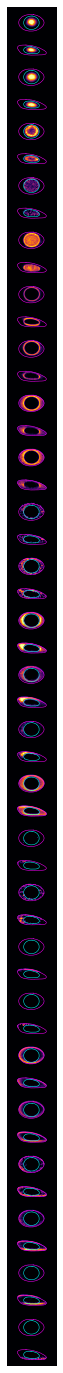

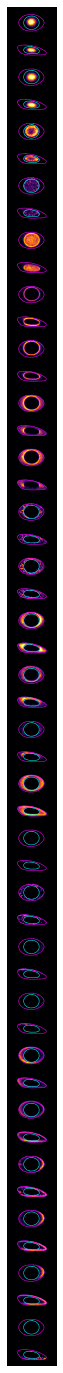

In [8]:
for ds, staging, dsname in zip(["edges","edges"], ["variance_edges","edge_cells_midpoint_expanded"], ["nonedge","edge"]):

    inner_alias = control_main.get_inner_most_alias_to_parameterize()
    outer_alias = control_main.get_outer_most_alias_to_parameterize()
    inner_mesh = device_main.read_vtk_polydata(f"avgshape/{ds}_{inner_alias}_matched.vtk")
    outer_mesh = device_main.read_vtk_polydata(f"avgshape/{ds}_{outer_alias}_matched.vtk")
    
    path_step = Path(f"/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_{staging}/shapemode")
    control, device = common.get_managers_from_step_path(path_step)

    row = pd.Series({"shape_mode": "NUC_MEM_PC1", "mpId": 1, "aggtype": "avg", "alias": "STR"})
    domain, domain_nuc, domain_mem, coords_param = common.get_map_point_shape(control, device, row, inner_mesh=inner_mesh, outer_mesh=outer_mesh)

    morphs = {}
    for gene in genes:
        row["structure"] = gene
        rep = device.read_agg_parameterized_intensity(row)
        morphed = cytoparam.morph_representation_on_shape(
            img=domain,
            param_img_coords=coords_param,
            representation=rep
        )
        morphed = np.stack([domain_nuc, domain_mem, morphed], axis=0)
        morphs[gene] = morphed
    
    instances = dict([(gene, [{"CellId": "mean","img": morphs[gene]}]) for gene in genes])
    common.make_contact_sheet_avgseg_channel(
        data = instances,
        bbox = 400,
        contrast = contrast,
        file_prefix = f"MovieEdges_{dsname}_gfp_morphed",
        nucleus_contour_off = ["LMNB1", "NUP153", "SEC61B", "ATP2A2", "HIST1H2BJ"]
    )

In [9]:
common.now("complete.")

complete. 2022-06-28 00:11:12
